In [1]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
import torch
import torch.nn as nn
from model_evaluation import get_vis_data, compare_sactter_plots
from sklearn.manifold import TSNE
from tqdm import tqdm
import numpy as np
from datapreperation import get_processed_input_examples_full
from peft import get_peft_model, LoraConfig
from torch.utils.data import DataLoader
import random
import os
from peft import PeftConfig, PeftModel


RANK = 2
PEFT_CONFIG = LoraConfig(inference_mode=False, 
              r=RANK, 
              lora_alpha=RANK*2, 
              lora_dropout=0.05,
              # target_modules=["q_lin","k_lin"]
              target_modules=['value','query']
              )


class MLPLayer(nn.Module):
    """
    Head for getting sentence representations over RoBERTa/BERT's CLS representation.
    """
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()
    def forward(self, features, **kwargs):
        x = self.dense(features)
        x = self.activation(x)
        return x
    

class STS_model(nn.Module): 
    def __init__(self, model_path, device='cpu', pef_config=None): 
      super(STS_model, self).__init__() 

      # Load model from HuggingFace Hub
      config = AutoConfig.from_pretrained(model_path, return_dict=True)
      self.device = device
      self.tokenizer = AutoTokenizer.from_pretrained(model_path)
      self.Bert_representations = AutoModel.from_pretrained(model_path)
      if pef_config is not None:
        self.Bert_representations = get_peft_model(self.Bert_representations, pef_config)
      self.Bert_representations.to(device)
      self.Bert_representations.print_trainable_parameters()
      self.MLP_layer = MLPLayer(config)
      self.MLP_layer.to(device)


        
    def forward(self, model_input): 
      # Tokenize sentences if input is a string or a list of strings
        if isinstance(model_input, str) or (isinstance(model_input, list) and isinstance(model_input[0], str)):
            model_input = self.tokenizer(model_input, padding=True, truncation=True, max_length=128, return_tensors="pt")
            model_input = model_input.to(self.device)
            model_output = self.Bert_representations(**model_input)
        else:
            model_output = self.Bert_representations(**model_input)
        
        # Get the representation of [CLS]
        model_output = model_output.last_hidden_state[:, 0, :]
        model_output = self.MLP_layer(model_output)
        return model_output


# Load TripletLoss data
data_path = './dataset/data.csv'
data = get_processed_input_examples_full(data_path)
cleaned_data = []
for q in data:
    if all(isinstance(item, str) for item in q.texts):
        cleaned_data.append(q)
data = cleaned_data


# Load Vis data
data_path = './dataset/data.csv'
questions, ids, node_names = get_vis_data(data_path=data_path)
questions = questions[:256]
ids = ids[:256]
node_names = node_names[:256]


    

Number of InputExamples: 1112200
Example of InputExample: ['السلام عليكم', 'سلام', 'عندي مشكلة']
Number of InputExamples after removing duplicates: 1055631


In [2]:
# Load Base model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
# model_name = 'sentence-transformers/all-MiniLM-L12-v1'
model_name = 'sentence-transformers/all-roberta-large-v1'
model = STS_model(model_name, device=device, pef_config=PEFT_CONFIG)
print('Loaded model to device: ', device)

trainable params: 196608 || all params: 355556352 || trainable%: 0.05529587613723745
Loaded model to device:  cpu


In [3]:
# Get embeddings from the base model for further comparison
bare_model_embeddings = []
for q in tqdm(questions):
    emb = model(q).detach().cpu().numpy()
    bare_model_embeddings.append(emb)   
bare_model_embeddings = np.array(bare_model_embeddings).squeeze()
bare_model_embeddings_2d = TSNE(n_components=2).fit_transform(bare_model_embeddings)
print('bare model embeddings shape: ', bare_model_embeddings.shape)
print('bare model embeddings 2d shape: ', bare_model_embeddings_2d.shape)

# Compare the bare model embeddings with themselves
# compare_sactter_plots(bare_model_embeddings_2d, bare_model_embeddings_2d, ids)


100%|██████████| 256/256 [03:35<00:00,  1.19it/s]


bare model embeddings shape:  (256, 1024)
bare model embeddings 2d shape:  (256, 2)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tuned_model = STS_model(model_name, device=device, pef_config=PEFT_CONFIG)
steps = 600
short_model_name = model_name.split('/')[-1]
mlp_model_path = f'./models/LoRa/mlp_model_{short_model_name}_{steps}.pth'
lora_model_path = f'./models/LoRa/lora_model_{short_model_name}_{steps}'
tuned_model.MLP_layer.load_state_dict(torch.load(mlp_model_path))
config = PeftConfig.from_pretrained(lora_model_path)
bert_model = AutoModel.from_pretrained(config.base_model_name_or_path)
inference_model = PeftModel.from_pretrained(bert_model, lora_model_path)
inference_model.to(device)
tuned_model.Bert_representations = inference_model


trainable params: 196608 || all params: 355556352 || trainable%: 0.05529587613723745


In [8]:

# Get embeddings from the tuned model for further comparison
tuned_model_embeddings = []
for q in tqdm(questions):
    emb = tuned_model(q).detach().cpu().numpy()
    tuned_model_embeddings.append(emb)
tuned_model_embeddings = np.array(tuned_model_embeddings).squeeze()
tuned_model_embeddings_2d = TSNE(n_components=2).fit_transform(tuned_model_embeddings)
print('tuned model embeddings shape: ', tuned_model_embeddings.shape)
print('tuned model embeddings 2d shape: ', tuned_model_embeddings_2d.shape)



100%|██████████| 256/256 [00:33<00:00,  7.62it/s]


tuned model embeddings shape:  (256, 1024)
tuned model embeddings 2d shape:  (256, 2)


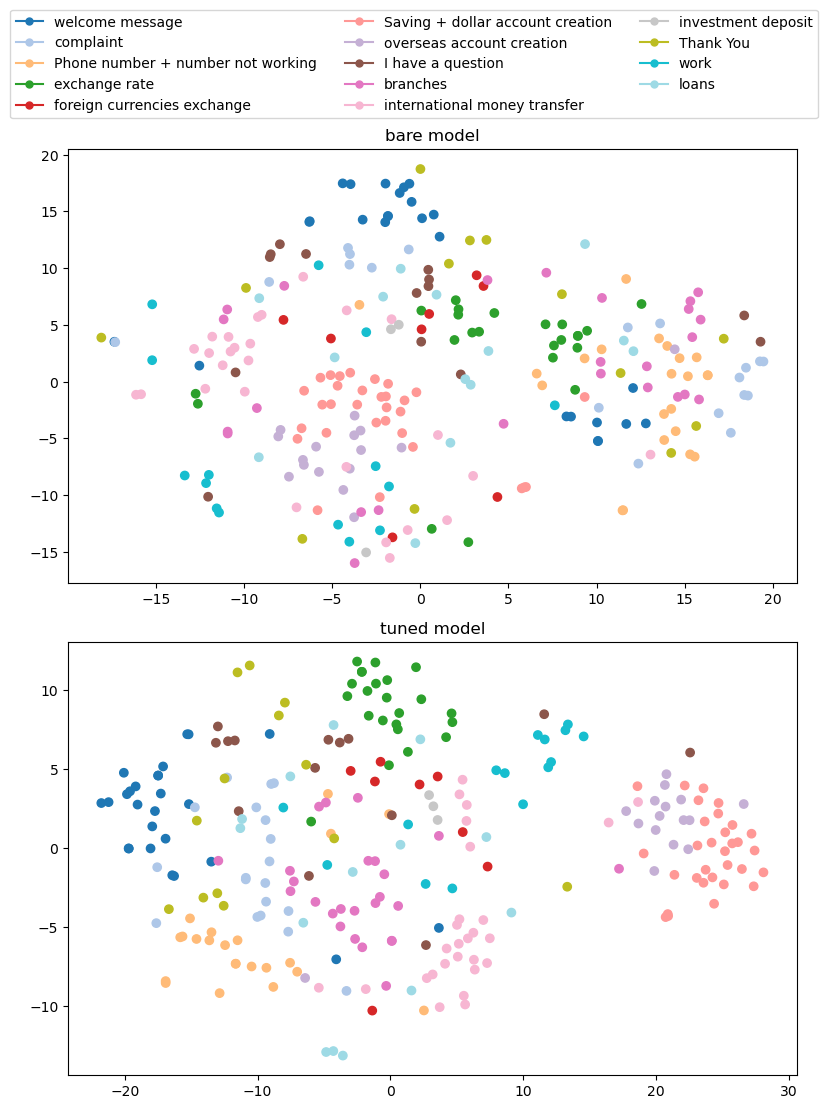

In [9]:
# Compare the bare model embeddings with the tuned model embeddings
compare_sactter_plots(bare_model_embeddings_2d, tuned_model_embeddings_2d, ids)

In [ ]:
# create dataloader for triplet texts in bathces
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, device='cpu', batch_size=None, shuffle=True):
        self.data = data
        if shuffle:
            random.shuffle(self.data)
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = 0
        for item in self.data:
            for text in item.texts:
                self.max_len = max(self.max_len, len(text))
        self.batch_size = batch_size
        self.batched_data = []
        if self.batch_size is not None:
            current_batch = []
            for i, item in enumerate(self.data):
                if i % self.batch_size == 0 and i != 0:
                    self.batched_data.append(current_batch)
                    current_batch = []
                current_batch.append(item.texts)
                #TODO: add Last batch with less than batch_size elements
            self.batched_data = np.array(self.batched_data)
            print('Batched data shape: ', self.batched_data.shape)

    def __len__(self):
        if self.batch_size is not None:
            return len(self.batched_data)
        else:
            return len(self.data)
    
    def __getitem__(self, idx):
        if self.batch_size is not None:
            batch = self.batched_data[idx]
            anchors = batch[:, 0].tolist()
            positives = batch[:, 1].tolist()
            negatives = batch[:, 2].tolist()
            encoded_anchors = self.tokenizer(anchors, padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')
            encoded_positives = self.tokenizer(positives, padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')
            encoded_negatives = self.tokenizer(negatives, padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')
            encoded_anchors.to(self.device)
            encoded_positives.to(self.device)
            encoded_negatives.to(self.device)
            return encoded_anchors, encoded_positives, encoded_negatives
        else:
            #TODO: implement __getitem__ for single elements
            pass


In [ ]:
# Set up training parameters
batch_size = 4
train_dataset = TripletDataset(data, model.tokenizer, device=device, batch_size=batch_size)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
num_epochs = 5
loss = 0
epoch=0
steps = 0
eval_every = 1000
total_loss = 0
save_model_every = 1000

In [ ]:
# Train the model
for epoch in range(num_epochs):
        
        epoch_loss = 0
        tbar = tqdm(train_dataset, unit='batch', desc=f'Epoch {epoch} current loss: {loss} ')
        
        for input in tbar:
                anchor = model(input[0])
                positive = model(input[1])
                negative = model(input[2])
                loss = triplet_loss(anchor, positive, negative)
                epoch_loss += loss.item()
                total_loss += loss.item()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                tbar.set_description(f'Epoch {epoch} current loss: {loss}')

                if steps+1 % eval_every == 0:
                        avarage_loss = total_loss / eval_every
                        total_loss = 0
                        print(f'Steps {steps} avarage loss: {avarage_loss}')
                        tuned_model_embeddings = []
                        for q in tqdm(questions):
                                emb = model(q).detach().cpu().numpy()
                                tuned_model_embeddings.append(emb)
                        tuned_model_embeddings = np.array(tuned_model_embeddings).squeeze()
                        tuned_model_embeddings_2d = TSNE(n_components=2).fit_transform(tuned_model_embeddings)
                        compare_sactter_plots(bare_model_embeddings_2d, tuned_model_embeddings_2d, ids)

                if steps % save_model_every == 0:
                        mlp_model = model.MLP_layer
                        lora_model = model.Bert_representations

                        if not os.path.exists('./models/LoRa'):
                                os.makedirs('./models/LoRa')

                        #model name without / character
                        short_model_name = model_name.split('/')[-1]
                        mlp_save_path = f'./models/LoRa/mlp_model_{short_model_name}_{steps}.pth'
                        lora_save_path = f'./models/LoRa/lora_model_{short_model_name}_{steps}'

                        torch.save(mlp_model.state_dict(), mlp_save_path)
                        lora_model.save_pretrained(lora_save_path)
                
                steps += 1

        print(f'Epoch loss: {epoch_loss}')
        
